In [1]:
from copy import deepcopy
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pymodulon.core import IcaData
from pymodulon.enrichment import compute_enrichment, FDR

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support


## Load annotation

In [141]:
## Load Metadata from each project
metadata = pd.read_csv('./data/transcriptome/Metadata_Perturbation_Passing_QC.csv', index_col=0)
metadata.rename(columns={"Project_tag":"project", "Condition":"condition"}, inplace=True)

ann = pd.read_excel("./data/transcriptome/SePCC7942_gene_annotation.xlsx", header=1)
ann = ann.loc[:,~ann.columns.str.match('Unnamed')]
ann.drop(ann.tail(1).index,inplace=True)
ann = ann[~ann.locus_tag_new.isna()]
ann.head()

,locus_tag_new,start,end,strand,feature_interval_length,product_length,# feature,class,assembly,assembly_unit,...,DeepTF_prediction,score.2,ENTRAF_seq_id,hmm acc,ENTRAF_hmm_name,Ortho,iTAK_Gene_ID,Family Name,Category,iTAK_Detail
0,H6G84_RS00005,171.0,1112.0,-,942.0,313.0,CDS,with_protein,GCF_014698905.1,Primary Assembly,...,0.0,0.0050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H6G84_RS00010,1173.0,1928.0,+,756.0,251.0,CDS,with_protein,GCF_014698905.1,Primary Assembly,...,0.0,0.0078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H6G84_RS00015,1929.0,2759.0,+,831.0,276.0,CDS,with_protein,GCF_014698905.1,Primary Assembly,...,0.0,0.0058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H6G84_RS00020,2898.0,3215.0,+,318.0,105.0,CDS,with_protein,GCF_014698905.1,Primary Assembly,...,0.0,0.0834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H6G84_RS00025,3296.0,5173.0,-,1878.0,625.0,CDS,with_protein,GCF_014698905.1,Primary Assembly,...,0.0,0.0083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load regulator values

In [142]:
regs = pd.read_csv("./data/transcriptome/TRN.csv")
regf = regs.rename(columns={'Regulator_Name':'regulator', 'Regulatee_Gene_ID':'gene_id'})
regf.drop('Regulator_Gene_ID', axis=1, inplace=True)
regf['effect'] = np.nan
regf

,regulator,gene_id,effect
0,RpaA,H6G84_RS07770,NaN
1,RpaA,H6G84_RS07765,NaN
2,RpaA,H6G84_RS07660,NaN
3,RpaA,H6G84_RS07565,NaN
4,RpaA,H6G84_RS07550,NaN
...,...,...,...
310,ArsR,H6G84_RS12975,NaN
311,L10_leader,H6G84_RS13385,NaN
312,L10_leader,H6G84_RS13380,NaN
313,glnA,H6G84_RS00250,NaN


## Load Modules 

In [4]:
M=pd.read_csv("./data/transcriptome/ICA_res/M.csv", index_col=0)
A=pd.read_csv("./data/transcriptome/ICA_res/A.csv", index_col=0)
X = pd.read_csv("./data/transcriptome/ICA_res/passing_logTPM_controlNorm_update110522.csv", index_col=0)

ica_data = IcaData(M,A,X)
ica_data.trn = regf

test_data = IcaData(ica_data.M,
                    ica_data.A,
                    trn=ica_data.trn,
                    threshold_method='kmeans')

ann_trim = ann[['locus_tag_new', 'product_accession', 'locus_tag_old', 'GeneID', 'start', 'end', 'strand',
    'COG', 'GOs', 'EC', 'KEGG_ko', 'KEGG_Pathway', 'KEGG_Module', 'KEGG_Reaction', 'KEGG_rclass', 
     'BRITE','KEGG_TC', 'CAZy', 'BiGG_Reaction', 'PFAMs', 'P2TF_description', 'DeepTF_prediction',
    'ENTRAF_hmm_name', 'iTAK_Detail']]

#ann_trim = ann_trim.rename(columns={'locus_tag_new':'gene'})
ann_trim = ann_trim.set_index('locus_tag_new')
ann_trim = ann_trim[ann_trim.index.isin(X.index)]

ica_data.gene_table = ann_trim
ica_data.sample_table = metadata


/Users/feng626/opt/anaconda3/envs/phenome/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/feng626/opt/anaconda3/envs/phenome/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/feng626/opt/anaconda3/envs/phenome/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/feng626/opt/anaconda3/envs/phenome/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

In [5]:
modules = []

for k in ica_data.imodulon_names:
    mod = deepcopy(ica_data.view_imodulon(k))
    mod['module'] = k
    modules.append(mod)
    
modules = pd.concat(modules)


In [7]:
# modules.to_csv("./data/transcriptome/modulon_genes.csv")

## Load the Cellbox output

In [37]:
cb_out = pd.read_csv("./data/transcriptome/Cellbox_res/top1k_summary.csv")
cb_out

,affector,target,mean,std_dev,Q1,median,Q3,p_values,q_values
0,H6G84_RS04855,H6G84_RS01130,-0.000152,0.004551,-0.000149,-2.996978e-08,0.000067,2.899429e-01,3.909623e-01
1,H6G84_RS00870,H6G84_RS01130,-0.000007,0.003614,-0.000161,1.236027e-07,0.000135,9.505394e-01,9.651654e-01
2,H6G84_RS08385,H6G84_RS01130,-0.000184,0.009983,-0.000051,4.246052e-07,0.000166,5.611748e-01,6.529480e-01
3,H6G84_RS09745,H6G84_RS01130,-0.000966,0.012772,-0.000211,-3.160925e-07,0.000058,1.692222e-02,3.855307e-02
4,H6G84_RS01795,H6G84_RS01130,-0.000498,0.011530,-0.000383,-8.889314e-07,0.000128,1.725616e-01,2.584411e-01
...,...,...,...,...,...,...,...,...,...
37675,H6G84_RS01390,58,-0.007879,0.102781,-0.012109,-1.649578e-04,0.007839,1.551846e-02,3.586235e-02
37676,H6G84_RS08975,58,-0.015527,0.126214,-0.012161,-2.811186e-05,0.009619,1.068090e-04,4.738684e-04
37677,H6G84_RS06645,58,-0.002465,0.182317,-0.024682,-7.119133e-04,0.007048,6.690388e-01,7.461709e-01
37678,H6G84_RS06185,58,-0.015921,0.174820,-0.017441,-2.948390e-04,0.011527,4.063186e-03,1.143312e-02


In [38]:
cb_out["noise"] = (cb_out["std_dev"] / cb_out["mean"]) ** 2

<Axes: >

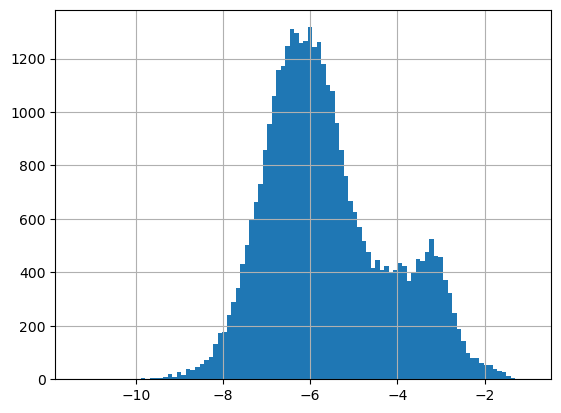

In [39]:
#| label: fig_w_dist
#| fig-cap: "Distribution: medians of W"

df = cb_out[cb_out["median"].abs() > 0].copy()
# df["median"].hist(bins=50)
np.log10(df["median"].abs()).hist(bins=100)

<Axes: >

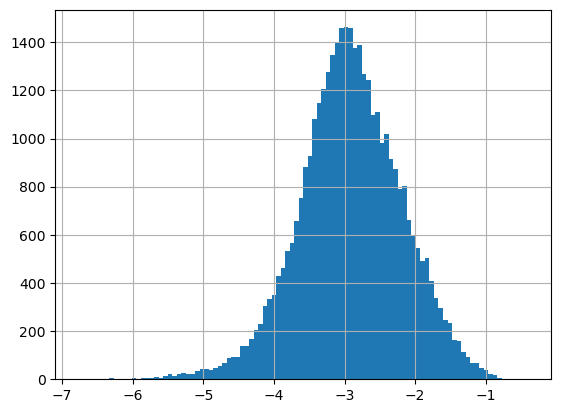

In [42]:
#| label: fig_w_dist
#| fig-cap: "Distribution: mean of W"

df = cb_out[cb_out["mean"].abs() > 0].copy()
# df["median"].hist(bins=50)
np.log10(df["mean"].abs()).hist(bins=100)

<Axes: >

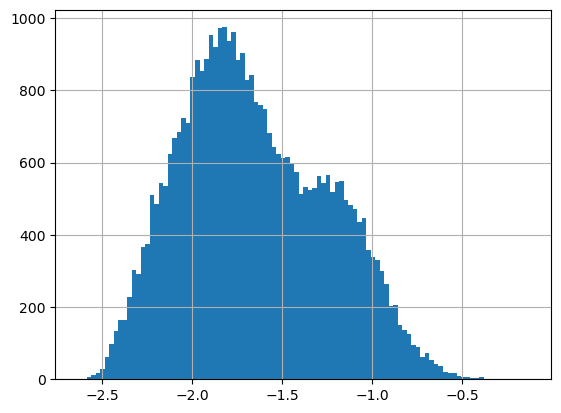

In [56]:
#| label: fig_w_dist
#| fig-cap: "Distribution: stds of W"

df = cb_out[cb_out["std_dev"].abs() > 0].copy()
# df["median"].hist(bins=50)
np.log10(df["std_dev"].abs()).hist(bins=100)
# df["std_dev"].abs().hist(bins=100)

<Axes: >

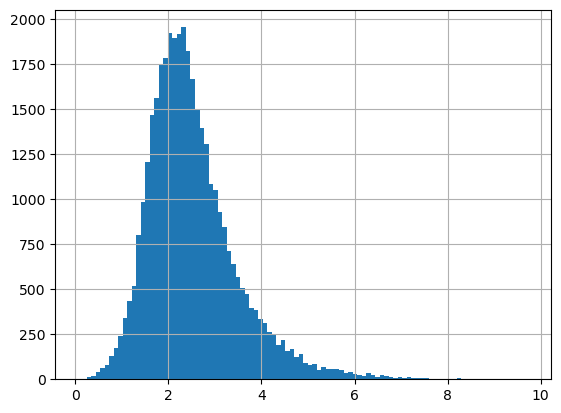

In [44]:
#| label: fig_w_dist
#| fig-cap: "Distribution: noise of W"

df = cb_out[cb_out["noise"].abs() > 0].copy()
# df["median"].hist(bins=50)
np.log10(df["noise"].abs()).hist(bins=100)

In [65]:
cb_out["strength"] = cb_out["median"]


In [88]:
nodes = pd.read_csv("./cellbox/RNA/20230310_cyano_rna/cyano_rna_node_index.csv", header=None)
# nodes

In [85]:
reg_nodes = nodes.iloc[:157,0].to_list()
# reg_nodes

In [86]:
phe_nodes = nodes.iloc[157:216,0].to_list()
# phe_nodes

In [87]:
pert_nodes = nodes.iloc[216:,0].to_list()
# pert_nodes

In [184]:
df_cb = cb_out[(cb_out["median"].abs() > 0.0001) & (cb_out["q_values"] < 1e-2)].copy()
df = df_cb[["affector", "target", "strength"]].copy()
df.shape

(4655, 3)

In [190]:
len(set(df[df["affector"].str.contains("H6G84")]["affector"].to_list() + df[df["target"].str.contains("H6G84")]["target"].to_list()))

157

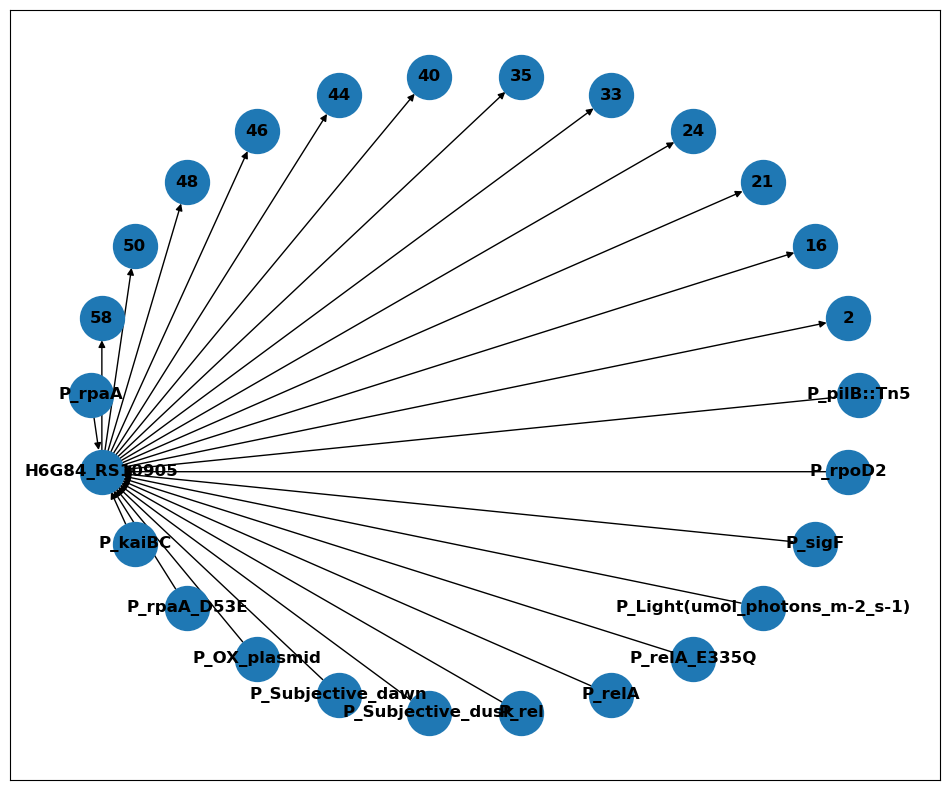

In [180]:
TF = "H6G84_RS10905"
df_tf = df[(df["affector"] == TF) | (df["target"] == TF)]
GN = nx.DiGraph()
GN.add_weighted_edges_from([tuple(x) for x in df_tf.values])
plt.figure(figsize=(12,10)) 
nx.draw_networkx(GN, pos=nx.shell_layout(GN), with_labels=True, node_size=1000, font_size=12, font_weight='bold')

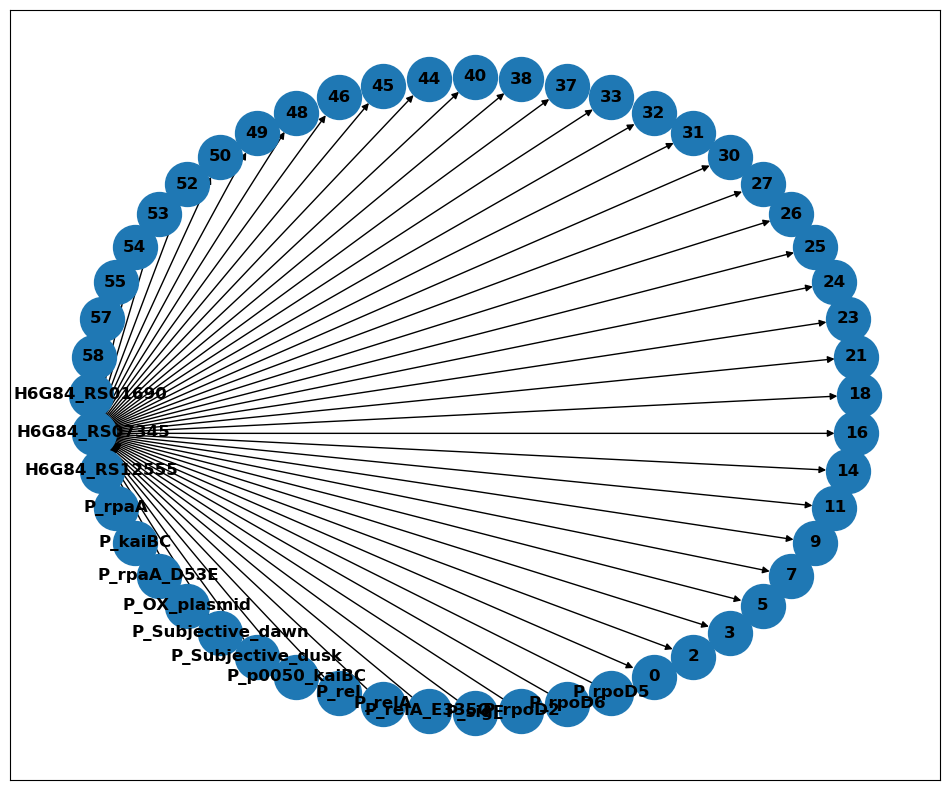

In [181]:
TF = "H6G84_RS07345"
df_tf = df[(df["affector"] == TF) | (df["target"] == TF)]
GN = nx.DiGraph()
GN.add_weighted_edges_from([tuple(x) for x in df_tf.values])
plt.figure(figsize=(12,10)) 
nx.draw_networkx(GN, pos=nx.shell_layout(GN), with_labels=True, node_size=1000, font_size=12, font_weight='bold')

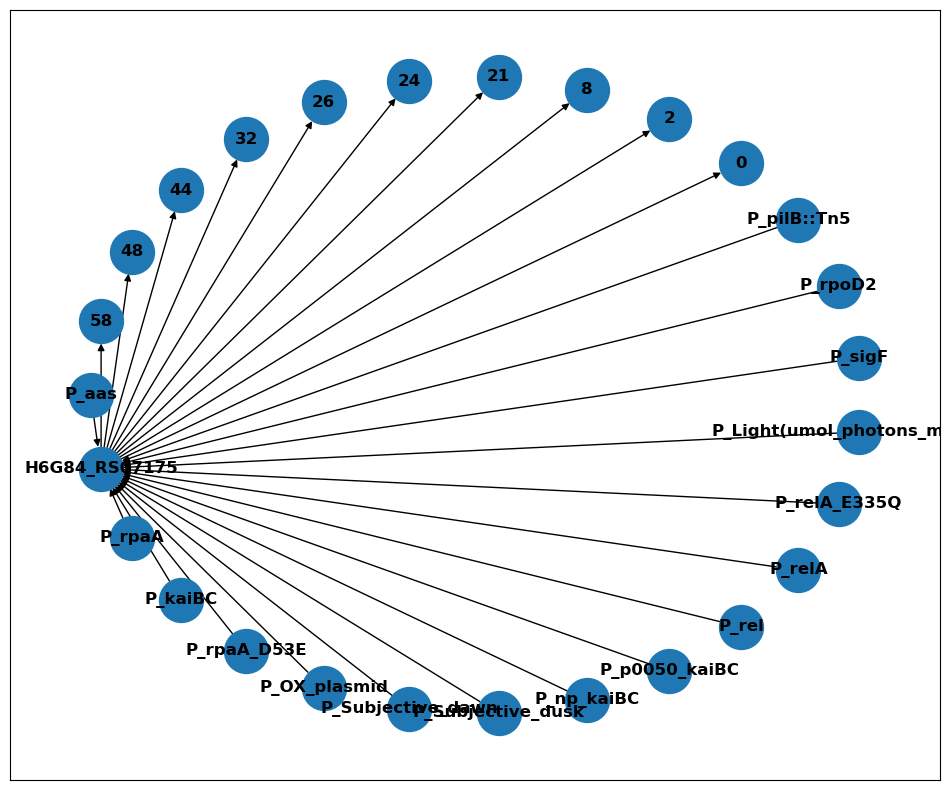

In [182]:
TF = "H6G84_RS07175"
df_tf = df[(df["affector"] == TF) | (df["target"] == TF)]
GN = nx.DiGraph()
GN.add_weighted_edges_from([tuple(x) for x in df_tf.values])
plt.figure(figsize=(12,10)) 
nx.draw_networkx(GN, pos=nx.shell_layout(GN), with_labels=True, node_size=1000, font_size=12, font_weight='bold')

## Load the DiGraph

In [151]:
df_reg = df[(df["affector"].isin(reg_nodes)) & (df["target"].isin(reg_nodes))].copy()
df_reg.shape

(29, 3)

In [183]:
df_reg

,affector,target,strength
301,H6G84_RS04295,H6G84_RS04855,0.000121
916,H6G84_RS03740,H6G84_RS01795,-0.000127
931,H6G84_RS01690,H6G84_RS01795,0.000104
1025,H6G84_RS04295,H6G84_RS01795,0.000144
2002,H6G84_RS03740,H6G84_RS11535,0.000324
2056,H6G84_RS13220,H6G84_RS11535,0.000117
2183,H6G84_RS11535,H6G84_RS03740,0.000110
2237,H6G84_RS13220,H6G84_RS03740,0.000319
3921,H6G84_RS04295,H6G84_RS05250,0.000103
3937,H6G84_RS02410,H6G84_RS05250,0.000106


In [153]:
GN = nx.DiGraph()
GN.add_weighted_edges_from([tuple(x) for x in df_reg.values])

In [154]:
# add the "label" attribute to each node based on the node function
for node in GN.nodes():
    if node.startswith('P_'):
        GN.nodes[node]['label'] = 'Perturbation'
        GN.nodes[node]['trophic_lvl'] = 0
    elif node.startswith('H6G84'):
        GN.nodes[node]['label'] = 'TF'
        GN.nodes[node]['trophic_lvl'] = 1
    else:
        GN.nodes[node]['label'] = 'Modulon'
        GN.nodes[node]['trophic_lvl'] = 2


In [155]:
node_attrs = [(node, data['label'], data['trophic_lvl']) for node, data in GN.nodes.data()]
node_labels = pd.DataFrame(node_attrs, columns=['node', 'label', 'level'])
node_labels['label'].value_counts()

label
TF    21
Name: count, dtype: int64

In [156]:
#list(nx.topological_sort(GN))

def nodes_with_cycles(G):
    cycles = list(nx.simple_cycles(G))
    nodes_in_cycles = set()
    
    for cycle in cycles:
        for node in cycle:
            nodes_in_cycles.add(node)
            
    return nodes_in_cycles

# Find nodes with edge cycles
nodes_in_cycles = nodes_with_cycles(GN)
print("Nodes with edge cycles:", nodes_in_cycles)

# sGN = GN.subgraph(nodes_in_cycles)
# nx.write_graphml(sGN, "cyclical.graphml")

Nodes with edge cycles: {'H6G84_RS13220', 'H6G84_RS12555', 'H6G84_RS01795', 'H6G84_RS03740', 'H6G84_RS01690', 'H6G84_RS11535', 'H6G84_RS07345'}


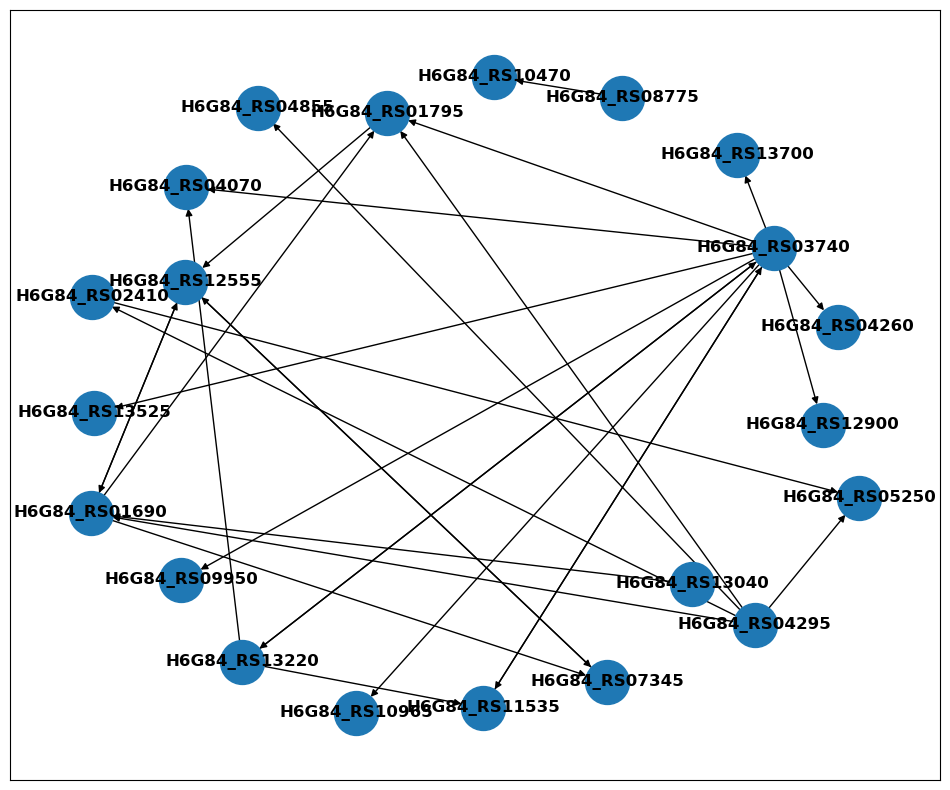

In [175]:
plt.figure(figsize=(12,10)) 
nx.draw_networkx(GN, pos=nx.spring_layout(GN), with_labels=True, node_size=1000, font_size=12, font_weight='bold')

## Graph is not directed acyclic graph because of complexity of TF-TF interactions 
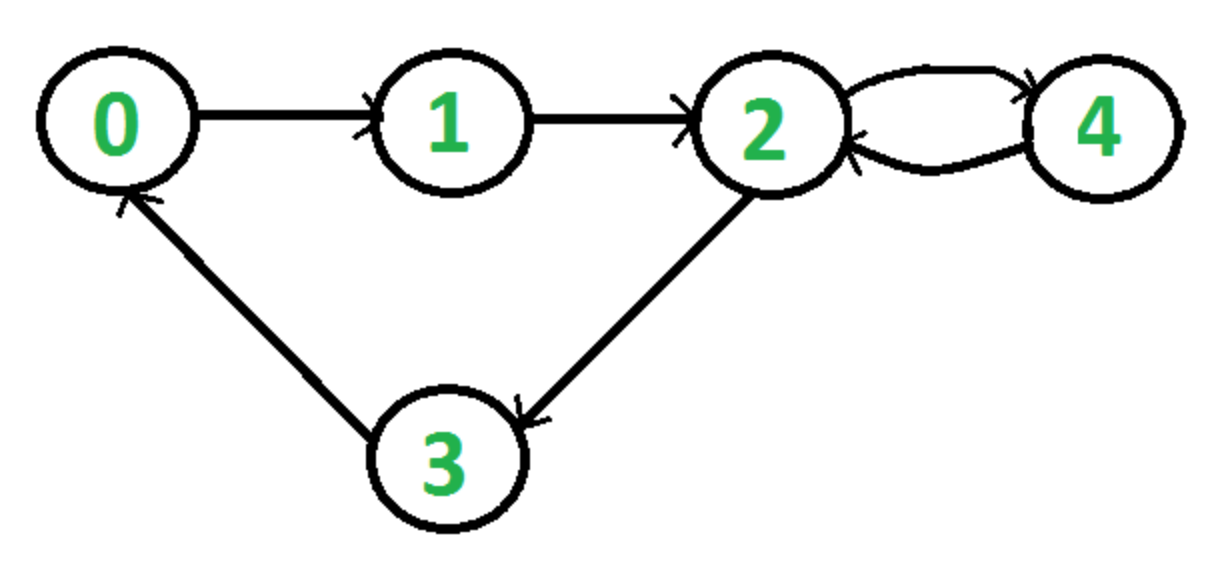
https://www.geeksforgeeks.org/detect-cycle-in-a-directed-graph-using-bfs/

## Evaluate the distribution of Perturbation nodes out degree:
How many TFs are associated each perturbation condition


In [95]:
perturbation_nodes = [node for node in GN.nodes() if GN.nodes[node]['label'] in ['Perturbation']]

# create the subgraph
pert_nx = nx.DiGraph()
for node in perturbation_nodes:
    pert_nx.add_node(node)
    neighbors = set(GN.neighbors(node))
    #Add neighbors
    pert_nx.add_nodes_from(neighbors)
    #Add neighbor edges
    pert_nx.add_edges_from([(node, neighbor) for neighbor in neighbors])
    
#Update node attributes
for node in pert_nx.nodes():    
    pert_nx.nodes[node].update(GN.nodes[node])

In [96]:
#Generate a pandas dataframe for the perturbation out degree
out_deg = []
for node, out_degree in pert_nx.out_degree():
    out_deg.append([node, GN.nodes[node]['label'], out_degree])
    
df = pd.DataFrame(out_deg, columns=['node', 'label', 'out_degree'])

In [101]:
df_sorted = df.sort_values('out_degree', ascending=False)
df_sorted

,node,label,out_degree
56,P_kaiBC,Perturbation,25
31,P_rpoD2,Perturbation,22
14,P_rpoD6,Perturbation,19
81,P_np_kaiBC,Perturbation,19
47,P_rpoD5,Perturbation,18
...,...,...,...
32,H6G84_RS12975,TF,0
30,H6G84_RS10470,TF,0
29,H6G84_RS07065,TF,0
28,H6G84_RS04070,TF,0


### Compare against the cellbox output

In [ ]:
known_regulators_cellbox = df_sorted.merge(
    reg_dist, left_on='node', right_on='Regulator_Gene_ID', how='right').merge(
    ann[['locus_tag_new','locus_tag_old']], left_on='node', right_on='locus_tag_new')

known_regulators_cellbox

,node,total_degree,TF-TF_degree,TF_mod_degree,Regulator_Name,Regulator_Gene_ID,count,locus_tag_new,locus_tag_old
0,H6G84_RS10905,2.0,0.0,2.0,RpaB,H6G84_RS10905,133,H6G84_RS10905,Synpcc7942_1453
1,H6G84_RS07345,3.0,0.0,3.0,RpaA,H6G84_RS07345,103,H6G84_RS07345,Synpcc7942_0095
2,H6G84_RS07175,5.0,0.0,5.0,NtcA,H6G84_RS07175,18,H6G84_RS07175,Synpcc7942_0127
3,H6G84_RS08775,3.0,1.0,2.0,NtcB,H6G84_RS08775,10,H6G84_RS08775,Synpcc7942_1242
4,H6G84_RS10085,3.0,0.0,3.0,Fur,H6G84_RS10085,8,H6G84_RS10085,Synpcc7942_0987
5,H6G84_RS08430,15.0,0.0,15.0,CcmR,H6G84_RS08430,6,H6G84_RS08430,Synpcc7942_1310
6,H6G84_RS12265,21.0,0.0,21.0,Zur,H6G84_RS12265,4,H6G84_RS12265,Synpcc7942_0817
7,H6G84_RS04755,3.0,0.0,3.0,PerR,H6G84_RS04755,4,H6G84_RS04755,Synpcc7942_1648
8,H6G84_RS13300,6.0,0.0,6.0,HrcA,H6G84_RS13300,2,H6G84_RS13300,Synpcc7942_0616
9,H6G84_RS08765,3.0,0.0,3.0,Crp,H6G84_RS08765,2,H6G84_RS08765,Synpcc7942_1243


<Axes: xlabel='out_degree', ylabel='Count'>

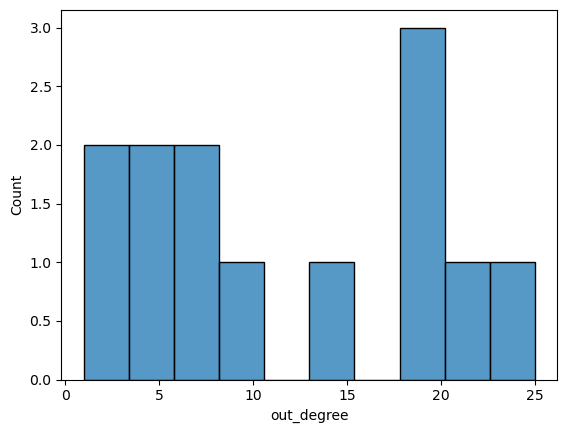

In [100]:
sns.histplot(df[df['label'] == 'Perturbation'], x='out_degree', bins=10)

In [102]:
## Find the number of TFs & Perturbation nodes
node_attrs = [(node, data['label'], data['trophic_lvl']) for node, data in pert_nx.nodes.data()]
node_labels = pd.DataFrame(node_attrs, columns=['node', 'label', 'level'])
node_labels['label'].value_counts()

label
TF              89
Perturbation    13
Name: count, dtype: int64

## Transcription Factor Analysis

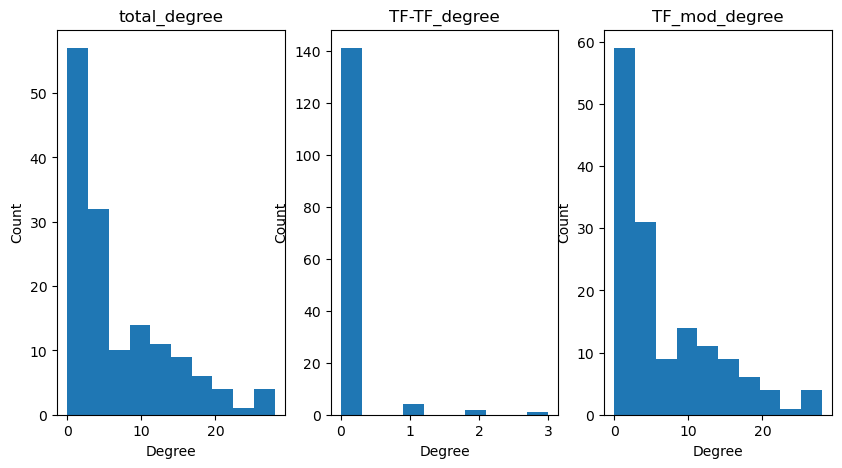

In [103]:
# Select nodes which are either TFs or Modulons (phenotype response)
TF_nodes = [node for node in GN.nodes() if GN.nodes[node]['label'] in ['TF', 'Modulon']]
TF_nx = GN.subgraph(TF_nodes)

#Define the degree of a TF, further break this down into TF-TF interactions and TF-modulon interactions
tot_degree = []
for node in TF_nx.nodes:
    if TF_nx.nodes[node]['label'] == 'TF':
        Total_deg = 0
        TF_TF_deg = 0
        TF_Mod_deg = 0
        for n_node in list(TF_nx.neighbors(node)):
            Total_deg += 1
            if n_node.startswith('H6G84'):
                TF_TF_deg += 1
            else:
                TF_Mod_deg += 1
        tot_degree.append((node, Total_deg, TF_TF_deg, TF_Mod_deg))
        
#Construct a datafame for the associated values
deg_dist = pd.DataFrame(tot_degree, columns=['node', 'total_degree', 'TF-TF_degree', 'TF_mod_degree'])
deg_dist


deg_dist_long = pd.melt(
    deg_dist, 
    id_vars=['node'], 
    value_vars=['total_degree', 'TF-TF_degree', 'TF_mod_degree'], 
    var_name='target', 
    value_name='degree'
)

#Plot the degree distribution 

dfs = {}
for target in deg_dist_long['target'].unique():
    dfs[target] = deg_dist_long.loc[deg_dist_long['target'] == target, 'degree']

# plot the histograms
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for i, target in enumerate(deg_dist_long['target'].unique()):
    axs[i].hist(dfs[target], bins=10)
    axs[i].set_title(target)
    axs[i].set_xlabel('Degree')
    axs[i].set_ylabel('Count')
    
plt.show()



In [104]:
#Top 10 TF with highest node degree
df_sorted = deg_dist.sort_values('total_degree', ascending=False)
print(f"Number of TFs without downstream connections:  {deg_dist[deg_dist['total_degree'] == 0].shape[0]}")
df_sorted.head(10)

Number of TFs without downstream connections:  6


,node,total_degree,TF-TF_degree,TF_mod_degree
57,H6G84_RS04985,28,0,28
98,H6G84_RS01595,27,0,27
36,H6G84_RS13525,26,0,26
94,H6G84_RS10220,26,0,26
61,H6G84_RS04070,25,0,25
103,H6G84_RS02950,22,0,22
101,H6G84_RS02765,21,0,21
50,H6G84_RS12265,21,0,21
100,H6G84_RS01735,20,0,20
46,H6G84_RS08425,19,0,19


# Analysis of TF-targets
### Get the distribution of regulators from the known TRN interactions

In [105]:
reg_dist = regs[['Regulator_Name','Regulator_Gene_ID']].value_counts().reset_index().rename(columns={0:'TF_degree'})
reg_dist.head()

,Regulator_Name,Regulator_Gene_ID,count
0,RpaB,H6G84_RS10905,133
1,RpaA,H6G84_RS07345,103
2,NtcA,H6G84_RS07175,18
3,NtcB,H6G84_RS08775,10
4,Fur,H6G84_RS10085,8


## Model selection function – weighted F1-score 

In [107]:
def bin_multilabel_known_trn_edgelist(regs, ann):
    '''
    Given a set of known regulatory interactions, 
    return a multi-label classifier dataframe in which each
    colum represents a regulator and each row a potential target
    1 denotes a regulatory edge and 0 denotes no edge
    '''

     #Create a new df from locus tags to build the binary index
    true_ann = ann[ann['# feature'] =='CDS'][['locus_tag_new']].copy()
    true_ann.set_index('locus_tag_new', inplace=True)

    #For known interactions where there is an edge annotate it with a 1
    for reg, df in regs.groupby('Regulator_Gene_ID'):
        true_ann.loc[true_ann.index.isin(df['Regulatee_Gene_ID']), reg] = 1

    #Where there is no known interactions return a 0
    true_ann = true_ann.fillna(0)
    true_ann.drop(columns=['RNA'], inplace=True)
    
    return(true_ann)


## Define nodes which have known regulatory interactions
### Construct a df containing information on the TF, modulon target, and the weight


In [108]:
known_nodes = [node for node in GN.nodes() if node in known_regulators_cellbox['node'].values]

# Instantiate the DiGraph class & add sigma factor nodes
known_nx = nx.DiGraph()  
for node in known_nodes:
    known_nx.add_node(node)
    
    #Add neighbors of sigma factors (targets = Modulons and TFs)
    neighbors = set(GN.neighbors(node))
    known_nx.add_nodes_from(neighbors)
    known_nx.add_edges_from([(node, neighbor) for neighbor in neighbors])
    
# Update node attributes (node class = Perturbation, TF, Modulon)
for node in known_nx.nodes():
    known_nx.nodes[node].update(GN.nodes[node])
    
# Update edge attributes (weights)
for edge in known_nx.edges():
    known_nx.edges[edge].update(GN.edges[edge])
    
    
#Create a pandas dataframe from the sigma factor targets
known_TF_targets_weights = []
# Select TF-targets based on whether they target a module
for TF, target, weight in known_nx.edges.data("weight"):
    if GN.nodes[target]['label'] == 'Modulon':
        known_TF_targets_weights.append((TF, target, weight))
known_tf_w = pd.DataFrame(known_TF_targets_weights, columns=['TF', 'Modulon', 'weight'])
known_tf_w.head()

,TF,Modulon,weight
0,H6G84_RS10905,35,-0.000242
1,H6G84_RS10905,16,-0.000174
2,H6G84_RS08775,35,0.000215
3,H6G84_RS08775,14,-0.000183
4,H6G84_RS07175,21,0.000605


## Calculate the weighted f1-score 

In [109]:

#Get TF scores 
TF_weighted_scores = []

#Calculate the multi-label binary for known TFs-gene targets
y_true = bin_multilabel_known_trn_edgelist(regs,ann)

# Iterate over TFs to calculate their association with modulons
for TF, targets in known_tf_w.groupby('TF'):
    
    #Given a TF and the number of target modulons, select TFs which have known interactions (from the multi-label binary arrray)
    #duplicate this arrray n times (the number of modulons targets) to construct an m*n array where m is the number of genes
    #This array is filled with the binary score for each gene, whether it is regulator or not by the same TF
    y_true_tf_n = np.tile(y_true[TF].values, (targets.shape[0],1)).T
    
    #Construct an empty dataframe containing all potential gene targets
    y_pred = ann[ann['# feature'] =='CDS'][['locus_tag_new']].copy()
    y_pred.set_index('locus_tag_new', inplace=True)
    #For each modulon, denote in the constructed dataframe whether the modulon contained a given gene
    #Where a gene is represented denote this with a 1, where it is not denote it with a 0
    for mod in targets.Modulon:
        y_pred.loc[y_pred.index.isin(modules[modules['module'] == int(mod)].index), mod] = 1
    y_pred = y_pred.fillna(0)
    
    #If there is only one modulon assigned to a TF, evaluate it as a binary classifer
    #Take the f1 score and multiply by the weight
    if targets.shape[0] == 1:
        precision, recall, f1, _ = precision_recall_fscore_support(y_true_tf_n, y_pred, zero_division=0, average='binary')
        TF_weighted_scores.append((TF, f1*targets.weight.abs().values[0]))
    #Otherwise evaluate as a multi-label binary classifier, select the f1-score for each TF-module association
    #multiply by the edge weight,then calculate the weighted f1-score average for each TF with mulitple modulon targets
    else:
        classification = classification_report(
            y_true_tf_n, y_pred, 
            target_names=y_pred.columns.values,
            zero_division=0, output_dict=True)
        
        TF_mods = pd.DataFrame(classification).T
        TF_mods = TF_mods.loc[~TF_mods.index.isin(['micro avg', 'macro avg', 'weighted avg', 'samples avg'])]
        TF_weighted_scores.append((TF, np.average(TF_mods['f1-score'].values * targets.weight.abs().values)))

#Agglomerate TF-modules weighted averages where there are modulon targets for a TF
TF_weighted_scores_df = pd.DataFrame(TF_weighted_scores, columns=['TF', 'score'])

#Otherwise assign known TFs with no modulon targets a score of 0
no_targets = reg_dist[(reg_dist['Regulator_Gene_ID'] != 'RNA') & 
                      (~reg_dist['Regulator_Gene_ID'].isin(TF_weighted_scores_df.TF))].drop(
                       columns=['Regulator_Name', 'TF_degree']).rename(columns={'Regulator_Gene_ID':'TF'}).copy()
no_targets['score'] = 0

#Combine the two dataframes and score the average TF F1-score across all known TFs
TF_weighted_scores_df = pd.concat([TF_weighted_scores_df, no_targets])
score = TF_weighted_scores_df['score'].mean()
print(score)

KeyError: "['TF_degree'] not found in axis"

In [110]:
highest_pert_tf = []
for node in GN.nodes():
    if GN.nodes[node]['label'] == 'Perturbation':
        edges = GN.out_edges(node, data='weight')
        sorted_edges = sorted(edges, key=lambda edge: abs(edge[2]), reverse=True)
        highest_pert_tf.append(sorted_edges[0])
        #highest_pert_tf.append(sorted_edges[1])
        #print(sorted_edges[0])
        
        #for node in GN.nodes():
            #if GN.nodes[node]['label'] == 'Perturbation':
        
test = pd.DataFrame(highest_pert_tf, columns=['Pert', 'TF', 'weight'])
test

merged_b = ann[ann['locus_tag_new'].isin(test.TF)][['locus_tag_new','locus_tag_old']]
merged = test.merge(merged_b, left_on='TF', right_on='locus_tag_new', how='left')

perturbation_nodes = [node for node in GN.nodes() if GN.nodes[node]['label'] in ['Perturbation']]

# create the subgraph
pert_nx = nx.DiGraph()
for node in perturbation_nodes:
    pert_nx.add_node(node)
    neighbors = set(GN.neighbors(node))
    #Add neighbors
    pert_nx.add_nodes_from(neighbors)
    #Add neighbor edges
    pert_nx.add_edges_from([(node, neighbor) for neighbor in neighbors])
    
#Update node attributes
for node in pert_nx.nodes():    
    pert_nx.nodes[node].update(GN.nodes[node])

In [111]:
## Simulation 

In [ ]:
# Panel B
def _simu(t_mu, W, alpha, eps, x_0 = np.zeros([99]), dT=0.1, n_T=100):
    def _dXdt(x):
        dXdt = eps[:, 0] * np.tanh(np.matmul(W, x) + t_mu) - alpha[:, 0] * x
        return dXdt
    
    x = x_0
    trace = x_0
    for i in range(n_T):
        """ Integrate with Heun's Method """
        dXdt_current = _dXdt(x)
        dXdt_next = _dXdt(x + dT * dXdt_current)
        x = x + dT * 0.5 * (dXdt_current + dXdt_next)
        trace = np.append(trace,x)
    trace = np.reshape(trace, [n_T+1, 99])
    return trace
def b(index = '000', condition = 0, nT = 400):

    #os.chdir(root+'/b11_'+index)
    os.chdir(root+'/seed_'+index)

#     alpha = pd.read_csv(glob.glob('*%d*json.4*alpha*csv'%nT)[0], index_col = 0).values
#     eps = pd.read_csv(glob.glob('*%d*json.4*eps*csv'%nT)[0], index_col = 0).values
#     w = pd.read_csv(glob.glob('*%d*json.4*W*csv'%nT)[0], index_col = 0).values
    alpha = pd.read_csv(glob.glob('6_best.alpha*csv')[0], index_col = 0).values
    eps = pd.read_csv(glob.glob('6_best.eps*csv')[0], index_col = 0).values
    w = pd.read_csv(glob.glob('6_best.W*csv')[0], index_col = 0).values

    pert = np.genfromtxt('../../../data/pert.csv', dtype = np.float32, delimiter = ',')
    expr = np.genfromtxt('../../../data/expr.csv', dtype = np.float32, delimiter = ',')
    pos = np.genfromtxt('random_pos.csv')

    noi = [2,3,31,40,82,83]
    trace = _simu(pert[condition], w, alpha, eps, n_T = int(nT))
    trace_subset = trace[:,noi].transpose()
    xs = np.linspace(0, nT/10, int(nT)+1)
    real = expr[condition, noi]

    for t, trace_i in enumerate(trace_subset):
        plt.axhline(y = real[t], xmax = 0.98, ls="dashed",  alpha = 0.8,
                    color = sns.color_palette("deep")[t])
                    
        plt.plot(xs, trace_i, color = sns.color_palette("deep")[t], 
                 label = noi_index[t], alpha = 0.8)


    #plt.axvline(x = nT/10, color="black", ls="dashed", alpha = 0.8, linewidth=2)
    return trace, real

## Testing defining significant values for a 3D numpy array
### Assumes that each Cellbox generated array (i,j) is compiled into an (i,j,n) array where n is the number of tests
### Test values imputed: 
1. n the number of interaction terms
2. baseline_mean (0 – assuming that there are no signifance for the majority of values) 
3. baseline_std: (played with and chosen at random)
4. significant_values: a list of indicies which will be modified from baseline to be significant
5. sig_value_means: a list of means which are different than 0
6. sig_value_stdevs: a list of std dev which correspond to each indice


In [3]:
def generate_test_3d_array(n, baseline_mean, baseline_std, significant_values, sig_value_means, sig_value_stdevs):
    rows = n
    columns = n
    depth = 1000

    # Create a 2D (n * n) array of baseline mean values (assuming mean of 0)
    mean_values = np.full((rows, columns), baseline_mean, dtype=np.float64)

    # Replace the mean values at significant positions
    for idx, (i, j) in enumerate(significant_values):
        mean_values[i, j] = sig_value_means[idx]

    # Initialize a 3D (n * n * 1000) array with zeros
    three_d_array = np.zeros((rows, columns, depth), dtype=np.float64)

    # Fill the 3D array with normal distributions based on the 2D array values
    for i in range(rows):
        for j in range(columns):
            mean = mean_values[i, j]
            std_dev = baseline_std if (i, j) not in significant_values else sig_value_stdevs[significant_values.index((i, j))]
            samples = np.random.normal(mean, std_dev, depth)
            three_d_array[i, j] = samples

    return three_d_array

# Example usage:
n = 100
baseline_mean = 0
baseline_std = 0.1
significant_values = [[0, 0], [5, 5], [9, 9]]
sig_value_means = [0.8, 0.01, 0.1]
sig_value_stdevs = [0.2, 0.2, 0.01]

result = generate_test_3d_array(n, baseline_mean, baseline_std, significant_values, sig_value_means, sig_value_stdevs)


## Function iterates over each column ( i ), row ( j )
### selecting the 3rd dimension array (distribution of predicted interaction values)
### Compute a simple students t-test to determine in interaction is significantly different than 0

In [4]:
from scipy import stats

def find_significant_indices(three_d_array, alpha=0.05):
    rows, columns, _ = three_d_array.shape
    significant_indices = []

    for i in range(rows):
        for j in range(columns):
            samples = three_d_array[i, j]
            t_stat, p_value = stats.ttest_1samp(samples, 0)

            if p_value < alpha:
                significant_indices.append([i, j])

    return significant_indices


In [5]:
significant_indices = find_significant_indices(result)

In [6]:
print(f'Number of interactions determined to be significant: {len(significant_indices)}\n\
proportion of interactions determined to be significant: {len(significant_indices)/(100*100)}')



Number of interactions determined to be significant: 500
proportion of interactions determined to be significant: 0.05


## All input values determined to be significant

In [7]:
for val in significant_values:
    if val in significant_indices:
        print("true")

true
true
true


## Example of a single array distribution & testing

mean: 0.009 
std dev: 0.099
p-value:3.372e-141


<AxesSubplot:ylabel='Count'>

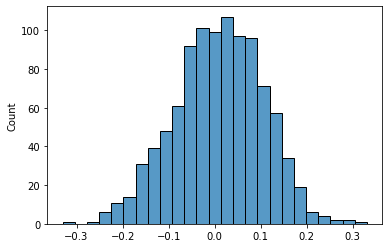

In [509]:
res = stats.ttest_1samp(result[9,9], 0)
print(f'mean: {result[5,5].mean():.3f} \nstd dev: {result[0,0].std():.3f}\np-value:{res[1]:.3e}')
sns.histplot(result[5, 5])

## Method described in the paper (simple t-test) does not include multiple testing correction. At least not described in the paper. The results shown here demonstrate that this results in a number of false positives as a result of multiple testing. Recompute with FDR correction with Benjamini-Hoch correction

In [10]:
def find_significant_indices_fdr(three_d_array, alpha=0.05):
    rows, columns, _ = three_d_array.shape
    p_values = []

    # Perform one-sample t-tests and collect p-values
    for i in range(rows):
        for j in range(columns):
            samples = three_d_array[i, j]
            _, p_value = stats.ttest_1samp(samples, 0)
            p_values.append(p_value)
            
    # Filter out NaN values
    non_nan_indices = ~np.isnan(p_values)
    non_nan_p_values = [p_value for p_value in p_values if not np.isnan(p_value)]

    # Apply FDR correction using Benjamini-Hochberg procedure
    rejected, corrected_p_values = smt.multipletests(non_nan_p_values, alpha=alpha, method='fdr_bh')[:2]

    # Map rejected and corrected_p_values back to the original size, filling with False and NaN, respectively
    rejected_full = np.full_like(p_values, False, dtype=bool)
    rejected_full[non_nan_indices] = rejected

    corrected_p_values_full = np.full_like(p_values, np.nan)
    corrected_p_values_full[non_nan_indices] = corrected_p_values

    # Find the significant indices
    significant_indices = [(i, j) for k, (i, j) in enumerate([(r, c) for r in range(rows) for c in range(columns)]) if rejected_full[k]]

    return significant_indices

In [11]:
import statsmodels.stats.multitest as smt

find_significant_indices_fdr(result)

[(0, 0), (9, 9)]

***FDR corrected values reduce our false discovery rate but now reduces sensitivity to true positives (as expected)***